In [1]:
import random
from typing import List, Dict, TypedDict
from langgraph.graph import StateGraph, END

In [3]:
class AgentState(TypedDict):
    name: str
    numbers: List[int]
    counter: int

In [4]:
def greeting(state: AgentState) -> AgentState:
    """"Greeting node which greets the user"""""
    state['name'] = f"Hi, {state['name']}!"
    state['counter'] = 0
    return state

In [6]:
def random_node(state: AgentState) -> AgentState:
    """"Random node which generates a random number"""""
    state['numbers'].append(random.randint(0, 10))
    state['counter'] += 1
    return state

In [9]:
def should_continue(state: AgentState) -> AgentState:
    """Function to decice what to do next"""
    if state['counter'] < 5:
        print("Entering the loog", state['counter'])
        return "Loop"
    else:
        return "Exit"

In [10]:
 graph = StateGraph(AgentState)

 graph.add_node("greeting", greeting)
 graph.add_node("random", random_node)
 graph.add_edge("greeting", "random")

 graph.add_conditional_edges(
     "random",              # Source Node
     should_continue,       # Action
     {"Loop": "random",     # Self Loop back to the same node
      "Exit": END}          # End the graph
 )

 graph.set_entry_point("greeting")

 app = graph.compile()

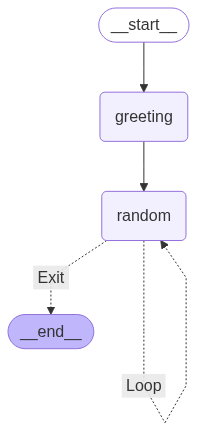

In [11]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
res = app.invoke({'name': 'Vaibhav', "numbers": [], "counter": -5})

Entering the loog 1
Entering the loog 2
Entering the loog 3
Entering the loog 4


In [14]:
res

{'name': 'Hi, Vaibhav!', 'numbers': [8, 3, 9, 5, 1], 'counter': 5}

# Exercise

In [44]:
class GameState(TypedDict):
    player_name: str
    target_number: int
    guesses: List[int]
    attempts: int
    hint: str
    lower_bound: int
    upper_bound: int

In [45]:
def setup_node(state: GameState) -> GameState:
    """Initialize the game with a random target number"""
    state["player_name"] = f"Welcome, {state['player_name']}!"
    state["target_number"] = random.randint(1, 20)
    state["guesses"] = []
    state["attempts"] = 0
    state["hint"] = "Game started! Try to guess the number."
    state["lower_bound"] = 1
    state["upper_bound"] = 20
    print(f"{state['player_name']} The game has begun. I'm thinking of a number between 1 and 20.")
    return state

In [46]:
def guess_node(state: GameState) -> GameState:
    """Generate a smarter guess based on previous hints"""

    possible_guesses = [i for i in range(state["lower_bound"], state["upper_bound"] + 1) if i not in state["guesses"]]
    if possible_guesses:
        guess = random.choice(possible_guesses)

    else:
        guess = random.randint(state["lower_bound"], state["upper_bound"])

    state["guesses"].append(guess)
    state["attempts"] += 1
    print(f"Attempt {state['attempts']}: Guessing {guess} (Current range: {state['lower_bound']}-{state['upper_bound']})")
    return state

In [47]:
def hint_node(state: GameState) -> GameState:
    """Here we provide a hint based on the last guess and update the bounds"""
    latest_guess = state["guesses"][-1]
    target = state["target_number"]

    if latest_guess < target:
        state["hint"] = f"The number {latest_guess} is too low. Try higher!"

        state["lower_bound"] = max(state["lower_bound"], latest_guess + 1)
        print(f"Hint: {state['hint']}")

    elif latest_guess > target:
        state["hint"] = f"The number {latest_guess} is too high. Try lower!"

        state["upper_bound"] = min(state["upper_bound"], latest_guess - 1)
        print(f"Hint: {state['hint']}")
    else:
        state["hint"] = f"Correct! You found the number {target} in {state['attempts']} attempts."
        print(f"Success! {state['hint']}")

    return state

In [48]:
def should_continue(state: GameState) -> str:
    """Determine if we should continue guessing or end the game"""

    # There are 2 end conditions - either 7 is reached or the correct number is guessed

    latest_guess = state["guesses"][-1]
    if latest_guess == state["target_number"]:
        print(f"GAME OVER: Number found!")
        return "end"
    elif state["attempts"] >= 7:
        print(f"GAME OVER: Maximum attempts reached! The number was {state['target_number']}")
        return "end"
    else:
        print(f"CONTINUING: {state['attempts']}/7 attempts used")
        return "continue"

In [49]:
graph = StateGraph(GameState)
graph.add_node("setup", setup_node)
graph.add_node("guess", guess_node)
graph.add_node("hint_node", hint_node)


graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint_node")


graph.add_conditional_edges(
    "hint_node",
    should_continue,
    {
        "continue": "guess",
        "end": END
    }
)

graph.set_entry_point("setup")
app = graph.compile()

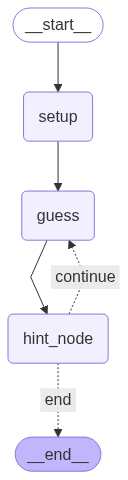

In [50]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [51]:
result = app.invoke({"player_name": "Vaibhav", "target_number": 9, "guesses": [], "attempts": 0, "hint": "", "lower_bound": 1, "upper_bound": 20})

Welcome, Vaibhav! The game has begun. I'm thinking of a number between 1 and 20.
Attempt 1: Guessing 6 (Current range: 1-20)
Hint: The number 6 is too high. Try lower!
CONTINUING: 1/7 attempts used
Attempt 2: Guessing 1 (Current range: 1-5)
Success! Correct! You found the number 1 in 2 attempts.
GAME OVER: Number found!
